In [1]:
# Dependencies
# !pip3 install mpld3
# !pip3 install casadi
# !pip3 install scipy


In [2]:
import numpy as np
from casadi import *

# Casadi Examples

https://web.casadi.org/docs/#document-ocp

In [3]:
x = MX.sym('x', 2, 2)
y = MX.sym('y')

z = 3 * x + y
print(z)

((3*x)+y)


In [4]:
print(jacobian(sin(z), x))

(zeros(4x4,4nz)[:4] = (all_3(2x2)*cos(((3*x)+y)))[:4])'


In [5]:
x = MX.sym('x')
y = MX.sym('y')
f = Function('x', [x, y], [y + sin(x)])

f(1., 1.)

jf = jacobian(f(x, y), x)
print(jf)

cos(x)


In [6]:
opti = Opti()

x = opti.variable()
y = opti.variable()

z = (x - 1.) ** 2 + y ** 2
opti.minimize(z)
opti.subject_to(x**2 + y**2 == 1)
opti.subject_to(x + y >= 1)

opti.set_initial(x, 0)
opti.set_initial(y, 0)

opti.solver('ipopt')

sol = opti.solve()

print('x: {}, y: {}, z: {}'.format(sol.value(x), sol.value(y), sol.value(z)))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        2
Number of nonzeros in inequality constraint Jacobian.:        2
Number of nonzeros in Lagrangian Hessian.............:        2

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

# Let's create a race car!!!

Inspired by CasADi usage examples

https://web.casadi.org/blog/ocp/


In [7]:
from casadi import *
from pylab import plot, step, figure, legend, show, spy
import matplotlib.pyplot as plt
import math

In [8]:
# choose a car
friction_acc = 6.

a_t_min = -5.
a_t_max = 3.

a_n_max = (friction_acc ** 2 - a_min ** 2) ** 0.5
a_n_min = -a_n_max

c_max = 0.2
c_min = -0.2

vehicle_width = 2.0
vehicle_length = 4.0
vehicle_back_to_axis = 1.0

In [9]:
# create a race track
Length = 250.
road_width = 10.
road_period = 35.
road_amplitude = 24.

# TODO: remove magic margin and process borders accurately
margin = vehicle_length - vehicle_back_to_axis

def road_center(x):
    return (cos(x / road_period) - 1) * road_amplitude

def road_curvature(x):
    # curvature of A * cos(x / T)
    A = road_amplitude
    T = road_period
    
    d = sqrt((A**2 * sin(x/T) ** 2)/T**2 + 1)
    l = ((A * cos(x/T))/((T**2 + A**2*sin(x/T)**2) * sqrt((A**2 * sin(x/T)**2)/T**2 + 1)))**2
    r = 1/4 * ((A**2 * sin((2 * x)/T))/(T**3 * ((A**2 * sin(x/T)**2)/T**2 + 1)**(3/2)))**2
    return sqrt(l + r) / d

def road_yaw(x):
    return - sin(x / road_period) * road_amplitude / road_period

def top_border(x, shift=0.):
    return road_center(x) + road_width / 2. + shift

def bottom_border(x, shift=0.):
    return road_center(x) - road_width / 2. + shift

In [10]:
# number of points in trajectory
N = 100

In [11]:
# Baseline solution
x_uniform = np.arange(N + 1) * Length / N
max_curvature = max(abs(np.array(road_curvature(x_uniform))))
v_max = math.sqrt(a_n_max / max_curvature)

# baseline solution - accelerate till max allowed speed limit and
# keep driving with it
t_acc = v_max / a_t_max
T_baseline = t_acc + (Length - t_acc ** 2 / 2) / v_max

print('''Baseline time is {0:.3f} sec.'''.format(T_baseline))

Baseline time is 22.829 sec.


In [12]:
# define system equation constraints

def system_equation(X, U):
    speed = X[v_id]
    yaw = X[yaw_id]
    derivatives = vertcat(
        speed * cos(yaw),
        speed * sin(yaw),
        speed * U[c_id],
        U[a_t_id]
    )
    return derivatives


def rotation_matrix(yaw):
    return np.array([[cos(yaw), -sin(yaw)], [sin(yaw), cos(yaw)]])

In [188]:
x_id, y_id, yaw_id, v_id = 0, 1, 2, 3
a_id, c_id = 0, 1


def initialize_optimizer(path_length_weight: float = 0.1):
    opti = Opti()

    # X = {x, y, yaw, v}
    X = opti.variable(4, N + 1)

    # U = {a, c}
    U = opti.variable(2, N)
    
    D = DM(np.diag(np.ones(N + 1)) - np.diag(np.ones(N), -1))
    rx = D @ X[x_id]
    ry = D @ X[y_id]

    T = opti.variable()

    opti.minimize(T + path_length_weight * (dot(rx, rx) + dot(ry, ry)))
    
    dt = T / N
    for i in range(N):
        # just Euler method
        x_next = X[:, i] + system_equation(X[:, i], U[:, i]) * dt
        opti.subject_to(X[:, i + 1] == x_next)

    opti.subject_to(X[v_id, :] >= 0)

    # start and finish constraints
    opti.subject_to(X[:, 0] == [0., 0., 0., 0.])
    opti.subject_to(X[x_id, -1] == Length)

    # improve stability
    opti.subject_to(X[y_id, -1] == road_center(Length))
    opti.subject_to(X[yaw_id, -1] == road_yaw(Length))

    # control constraints
    opti.subject_to(U[a_id, :] <= a_max)
    opti.subject_to(U[a_id, :] >= a_min)

    opti.subject_to(U[c_id, :] <= c_max)
    opti.subject_to(U[c_id, :] >= c_min)

    # normal acc. constraint
    opti.subject_to((U[c_id, :] * X[v_id, :-1] ** 2) ** 2 + U[a_id] ** 2 <= friction_acc ** 2)

    # time constraint
    opti.subject_to(T >= 0.)
    
    # prepare initial trivial solution - race slowly in the middle in the track
    v_init = v_max
    T_init = Length / v_init
    x_init = v_init * np.arange(N + 1) * T_init / N

    opti.set_initial(T, T_init)
    opti.set_initial(X[v_id, :], v_init)
    opti.set_initial(X[x_id, :], x_init)
    opti.set_initial(X[y_id, :], road_center(x_init))
    
    return opti, X, U, T

In [189]:
opti, X, U, T = initialize_optimizer(path_length_weight=0)

# road border constraints
opti.subject_to(X[y_id, :] <= top_border(X[x_id, :]) - margin)
opti.subject_to(X[y_id, :] >= bottom_border(X[x_id, :]) + margin)

# Solve
opti.solver('ipopt', {'ipopt': {'print_level': 0}})
solution = opti.solve()

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.88ms (  2.34us)   1.87ms (  2.33us)       803
       nlp_g  | 121.22ms (150.96us) 121.35ms (151.12us)       803
  nlp_grad_f  |   2.71ms (  5.44us)   2.66ms (  5.34us)       498
  nlp_hess_l  | 288.07ms (548.71us) 287.94ms (548.46us)       525
   nlp_jac_g  | 383.71ms (725.35us) 383.73ms (725.39us)       529
       total  |   4.64 s (  4.64 s)   4.64 s (  4.64 s)         1


Congratulations, you completed the race!!!
    Your track time is 16.007 sec., baseline time is 22.829 sec.


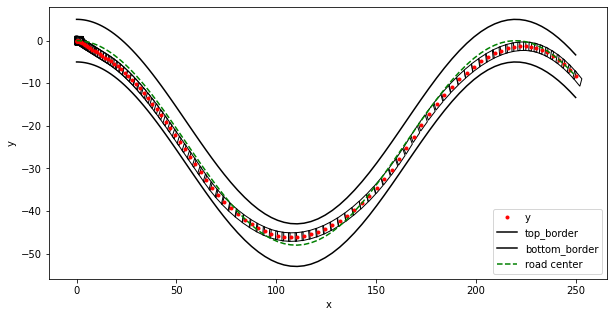

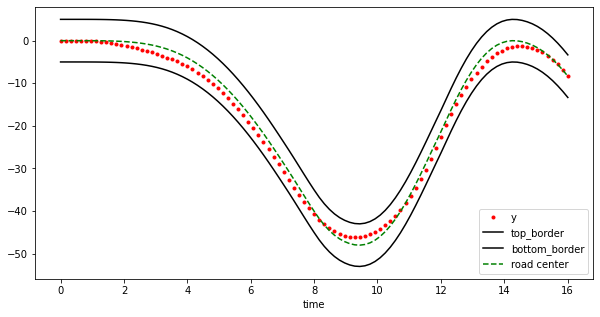

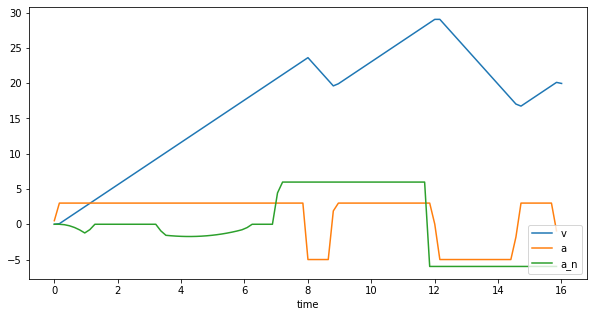

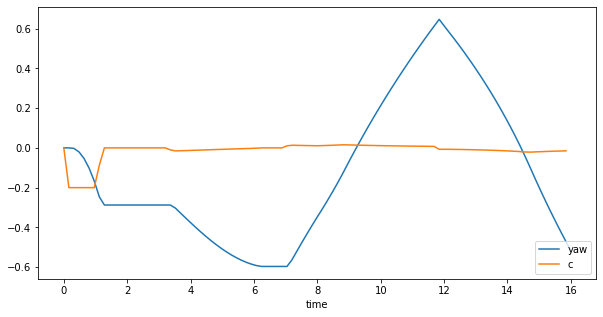

In [190]:
# plot solution

import mpld3
from matplotlib import patches
%matplotlib inline
mpld3.enable_notebook()
plt.rcParams["figure.figsize"] = [10, 5]


def visualize(X, U, T, obstacle_coords=None, trajectory_only=False):
    x_s = solution.value(X[x_id, :])
    y_s = solution.value(X[y_id, :])
    v_s = solution.value(X[v_id, :])

    yaw_s = solution.value(X[yaw_id, :])
    c_s = solution.value(U[c_id, :])
    a_s = solution.value(U[a_id, :])
    T_s = solution.value(T)
    t_u = np.arange(N + 1) * T_s / N

    print('''Congratulations, you completed the race!!!
    Your track time is {0:.3f} sec., baseline time is {1:.3f} sec.'''.format(T_s, T_baseline))


    plot(x_s, y_s, 'r.', label='y')
    plot(x_s, top_border(x_s), 'k-', label='top_border')
    plot(x_s, bottom_border(x_s), 'k-', label='bottom_border')
    plot(x_s, road_center(x_s), 'g--', label='road center')
    plt.xlabel('x')
    plt.ylabel('y')

    for x, y, yaw in zip(x_s, y_s, yaw_s):
        center = np.array([[x], [y]]) + rotation_matrix(yaw).dot(np.array([[-vehicle_back_to_axis], [-vehicle_width/2]]))
        rect = plt.Rectangle(center, vehicle_length, vehicle_width, angle=math.degrees(yaw), facecolor='none', linewidth=1, edgecolor='k')
        plt.gca().add_patch(rect)
    legend(loc='lower right')
    
    if obstacle_coords is not None:
        plt.gca().add_patch(plt.Circle(obstacle_coords[:2], obstacle_coords[2], color='black'))
        
    if trajectory_only:
        show()
        return

    figure()
    plot(t_u, y_s, 'r.', label='y')
    plot(t_u, top_border(x_s), 'k-', label='top_border')
    plot(t_u, bottom_border(x_s), 'k-', label='bottom_border')
    plot(t_u, road_center(x_s), 'g--', label='road center')
    plt.xlabel('time')
    legend(loc='lower right')

    figure()
    # plot(x_s, label='x')
    plot(t_u, v_s, label='v')
    plot(t_u[:-1], a_s, label='a')
    plot(t_u[:-1], c_s * v_s[:-1] ** 2, label='a_n')
    plt.xlabel('time')
    legend(loc='lower right')

    figure()
    plot(t_u, yaw_s, label='yaw')
    plot(t_u[:-1], c_s, label='c')
    plt.xlabel('time')
    legend(loc='lower right')

    show()


visualize(X, U, T)

In [191]:
GLOBAL_TO_AXIS_COORDS = np.array([-vehicle_back_to_axis, -vehicle_width / 2, 0])

def get_car_corners():
    fl_offset = [vehicle_length, vehicle_width, 0]
    fr_offset = [vehicle_length, 0, 0]
    rl_offset = [0, vehicle_width, 0]
    rr_offset = [0, 0, 0]
    return np.array([fl_offset, fr_offset, rl_offset, rr_offset]) + GLOBAL_TO_AXIS_COORDS
    

def warp_keypoints(X, keypoints):
    N_keypoints = keypoints.shape[0]
    N = X.shape[1]
    rotation_matrices = [rotation_matrix(X[yaw_id, i]) for i in range(N)]
    rotated_offsets = np.dot(rotation_matrices, keypoints[:, :2].T)  # warp only coordinates, not radius
    rotated_offsets = np.transpose(rotated_offsets, [0, 2, 1])
    warped = rotated_offsets.reshape(N, 2 * N_keypoints)
    for i in range(N):
        for j in range(N_keypoints):
            warped[i, 2*j] += X[x_id, i]
            warped[i, 2*j+1] += X[y_id, i]
    return warped.T


def add_road_border_constraints(opti, X):
    car_corners = warp_keypoints(X, get_car_corners())
    for i in range(X.shape[1]):
        opti.subject_to(car_corners[1, i] <= top_border(car_corners[0, i]))     # front left
        opti.subject_to(car_corners[1, i] >= bottom_border(car_corners[0, i]))
        opti.subject_to(car_corners[3, i] <= top_border(car_corners[2, i]))     # front right
        opti.subject_to(car_corners[3, i] >= bottom_border(car_corners[2, i]))
        opti.subject_to(car_corners[5, i] <= top_border(car_corners[4, i]))  # rear left
        opti.subject_to(car_corners[5, i] >= bottom_border(car_corners[4, i]))
        opti.subject_to(car_corners[7, i] <= top_border(car_corners[6, i]))  # rear right
        opti.subject_to(car_corners[7, i] >= bottom_border(car_corners[6, i]))

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 243.00us (  2.70us) 232.82us (  2.59us)        90
       nlp_g  |  77.40ms (860.00us)  77.54ms (861.61us)        90
  nlp_grad_f  | 316.00us (  5.64us) 295.37us (  5.27us)        56
  nlp_hess_l  | 119.50ms (  2.21ms) 120.18ms (  2.23ms)        54
   nlp_jac_g  | 119.05ms (  2.13ms) 119.45ms (  2.13ms)        56
       total  | 743.44ms (743.44ms) 744.97ms (744.97ms)         1
Congratulations, you completed the race!!!
    Your track time is 15.508 sec., baseline time is 22.829 sec.


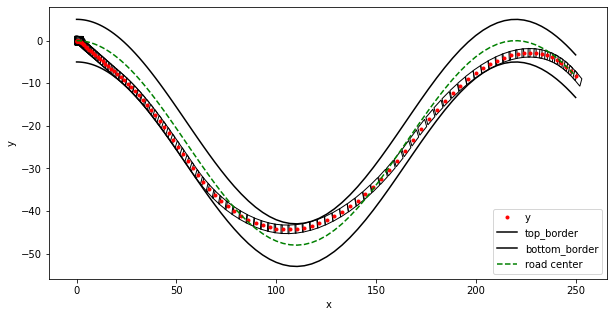

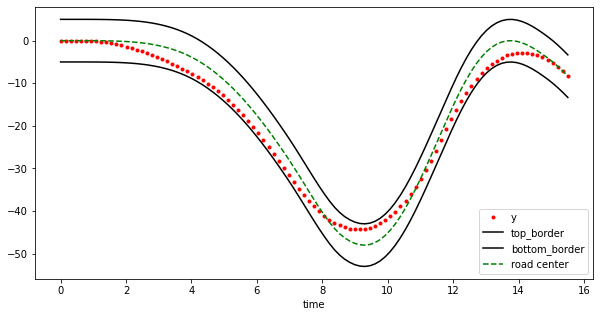

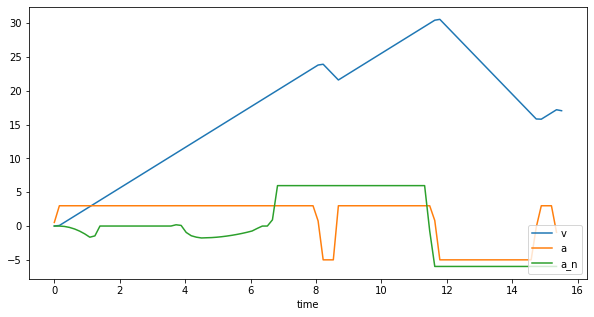

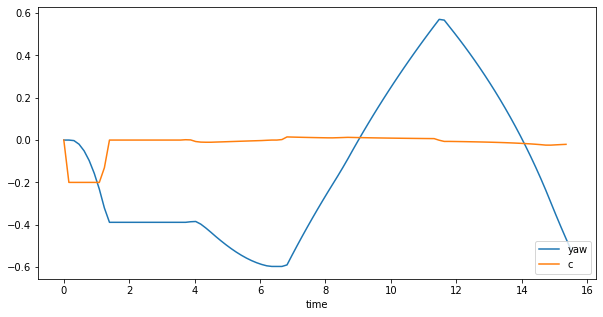

In [192]:
opti, X, U, T = initialize_optimizer(path_length_weight=0)
add_road_border_constraints(opti, X)

opti.solver('ipopt', {'ipopt': {'print_level': 0}})
solution = opti.solve()

visualize(X, U, T)

Видим, что уточнённая проверка позволила выиграть ещё 0.5 с, а сама траектория выглядит значительно лучше :)

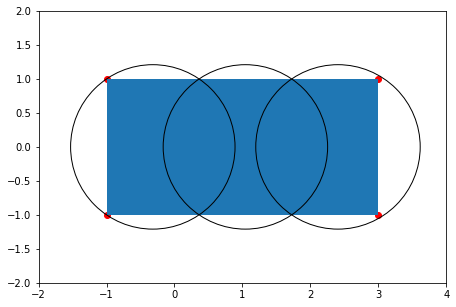

Congratulations, you completed the race!!!
    Your track time is 15.508 sec., baseline time is 22.829 sec.


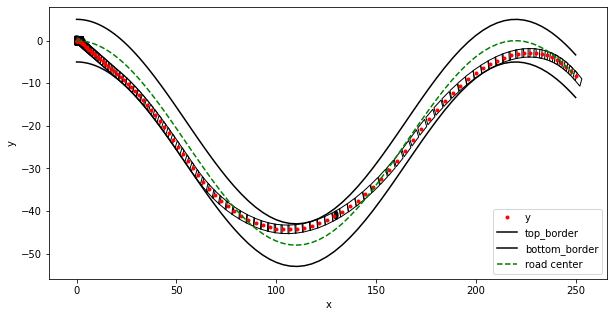

In [210]:
OBSTACLE = np.array([130, -41, 1])
COVERING_CIRCLE_RADIUS = 1.21


def get_car_covering_circles():
    offset = (COVERING_CIRCLE_RADIUS ** 2 - vehicle_width ** 2 / 4) ** 0.5
    circle_centers = []
    circle_num = 0
    while 2 * circle_num * offset < vehicle_length:
        circle_centers.append(np.array([(2 * circle_num + 1) * offset,
                                        vehicle_width / 2,
                                        COVERING_CIRCLE_RADIUS]))
        circle_num += 1
    return np.array(circle_centers) + GLOBAL_TO_AXIS_COORDS


def add_obstacle_constraints(opti, X):
    keypoints = np.vstack((get_car_corners(), get_car_covering_circles()))
    N_keypoints = keypoints.shape[0]
    warped_keypoints = warp_keypoints(X, keypoints).reshape(X.shape[1], -1, 2)
    obstacle_coords = OBSTACLE[:2]
    obstacle_radius = OBSTACLE[2]
    for i in range(X.shape[1]):
        for kp_idx in range(N_keypoints):
            x, y = warped_keypoints[i, kp_idx]
            ox, oy = obstacle_coords
            min_distance = keypoints[kp_idx][2] + obstacle_radius
            opti.subject_to((ox-x)**2+(oy-y)**2 >= min_distance ** 2)


def plot_keypoints(keypoints):
    fig = plt.Figure(figsize=(10, 5))
    
    car = plt.Rectangle((-vehicle_back_to_axis, -vehicle_width / 2), vehicle_length, vehicle_width)
    plt.gca().add_patch(car)
    
    plt.scatter(keypoints[:, 0], keypoints[:, 1], color='r')
    
    plt.scatter(0, 0, color='orange')  # center of rear axle
    
    for kp in keypoints:
        kp_circle = plt.Circle(kp[:2], kp[2], fill=False)
        plt.gca().add_patch(kp_circle)
        
    plt.xlim(-2, 4)
    plt.ylim(-2, 2)
    plt.gca().set_aspect('equal')
    
    plt.show()
    

plot_keypoints(np.vstack((get_car_corners(), get_car_covering_circles())))
visualize(X, U, T, OBSTACLE, trajectory_only=True)

In [225]:
solution.value(X[:2, :])

array([[ 0.00000000e+00, -1.13012305e-28,  1.27992807e-02,
         9.77474767e-02,  2.54815126e-01,  4.83764282e-01,
         7.83748842e-01,  1.15269413e+00,  1.58646769e+00,
         2.07786943e+00,  2.62387319e+00,  3.23664623e+00,
         3.91618905e+00,  4.66250165e+00,  5.47558402e+00,
         6.35543617e+00,  7.30205808e+00,  8.31544975e+00,
         9.39561118e+00,  1.05425423e+01,  1.17562432e+01,
         1.30367139e+01,  1.43839542e+01,  1.57979641e+01,
         1.72787437e+01,  1.88262931e+01,  2.04423789e+01,
         2.21261665e+01,  2.38678075e+01,  2.56618036e+01,
         2.75048630e+01,  2.93943778e+01,  3.13292500e+01,
         3.33084076e+01,  3.53312088e+01,  3.73973884e+01,
         3.95070498e+01,  4.16606740e+01,  4.38591346e+01,
         4.61037165e+01,  4.83961355e+01,  5.07385660e+01,
         5.31359075e+01,  5.55928271e+01,  5.81094237e+01,
         6.06983189e+01,  6.34261157e+01,  6.62888288e+01,
         6.92822903e+01,  7.24021747e+01,  7.56440193e+0

In [226]:
warped_circles = warp_keypoints(solution.value(X), get_car_corners()).reshape(-1, 4, 2)

warped_circles

array([[[ 3.00000000e+00,  3.00000000e+00],
        [ 3.01534918e+00,  3.11672228e+00],
        [ 3.30186587e+00,  3.56638138e+00],
        [ 3.90325722e+00,  4.30218876e+00]],

       [[ 4.74874431e+00,  5.23308437e+00],
        [ 5.77908765e+00,  6.39186069e+00],
        [ 7.07140350e+00,  7.81771610e+00],
        [ 8.63079847e+00,  9.51065060e+00]],

       [[ 1.04572725e+01,  1.14706642e+01],
        [ 1.25508256e+01,  1.36977567e+01],
        [ 1.49114576e+01,  1.61919282e+01],
        [ 1.75391684e+01,  1.89531784e+01]],

       [[ 2.04339580e+01,  2.19820625e+01],
        [ 2.35984009e+01,  2.52794478e+01],
        [ 2.70162011e+01,  2.88035790e+01],
        [ 3.06384527e+01,  3.25189318e+01]],

       [[ 3.44440523e+01,  3.64130659e+01],
        [ 3.84256268e+01,  4.04817503e+01],
        [ 4.25818076e+01,  4.47265358e+01],
        [ 4.69170526e+01,  4.91548738e+01]],

       [[ 5.14419352e+01,  5.37818002e+01],
        [ 5.61790950e+01,  5.86360198e+01],
        [ 6.11587696e+

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.17ms (  3.47us)   1.12ms (  3.31us)       338
       nlp_g  | 589.57ms (  1.74ms) 593.81ms (  1.76ms)       338
  nlp_grad_f  | 772.00us (  6.33us) 775.86us (  6.36us)       122
  nlp_hess_l  | 694.26ms (  5.79ms) 722.02ms (  6.02ms)       120
   nlp_jac_g  | 587.92ms (  4.82ms) 609.87ms (  5.00ms)       122
       total  |   3.73 s (  3.73 s)   3.83 s (  3.83 s)         1
Congratulations, you completed the race!!!
    Your track time is 15.508 sec., baseline time is 22.829 sec.


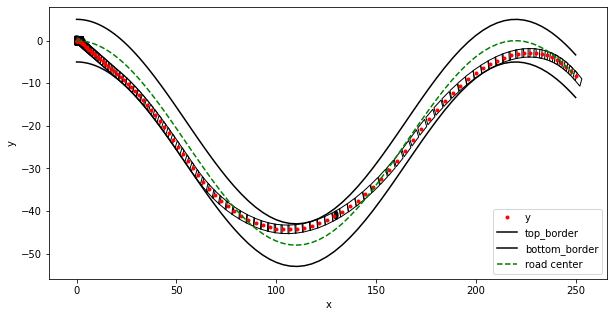

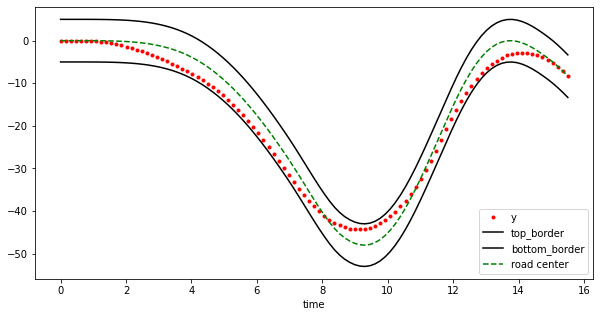

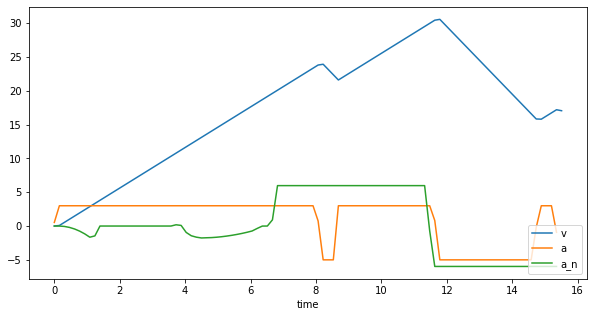

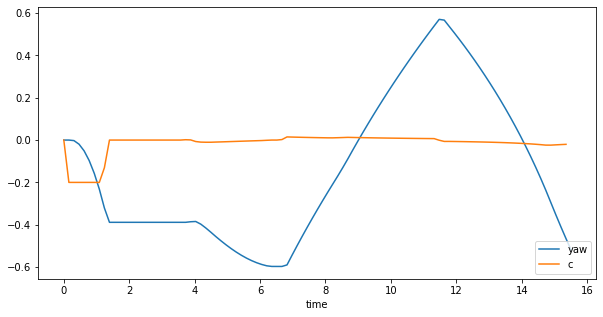

In [211]:
opti, X, U, T = initialize_optimizer(path_length_weight=0)
add_road_border_constraints(opti, X)
add_obstacle_constraints(opti, X)

opti.solver('ipopt', {'ipopt': {'print_level': 0}})
solution = opti.solve()

visualize(X, U, T, OBSTACLE)

**Home assignment (Russian)**

* максимальная оценка за домашнее задание 10 баллов

В примере на семинаре было сделано несколько допущений, улучшив которые, вы можете построить более быструю траекторию.

* Уточнить ограничение на нормальное и тангенциальное ускорение. (2 балла)

Нормальное и тангенциальное ускорение нужно выбирать таким, чтобы результирующий вектор ускорения не превышал силу трения.

Результирующее ускорение считается как векторная сумма нормального и тангенциального ускорения.

`a ** 2 = a_n ** 2 + a_t ** 2`

То есть лимит a_t_min, a_t_max, a_n_max, a_n_min надо заменить на лимит по friction_acc.
Лимит a_t_max при этом остаётся, так как это ограничение на максимальный момент двигателя.

**В отчёт** надо добавить график величины результирующего ускорения.


* Уточнить проверку границы дороги (4 балла)

На семинаре мы отступили по 3 метра от границы дороги. 
В домашнем задании вам предстоит написать более точную проверку, 
что позволит автомобилю использовать всё свободное пространство.

Подсказка: один из вариантов реализации это проверка, что углы прямоугольника находятся внутри дорожного полотна.

**В отчёте** должен быть график, показывающий границы дороги и габариты автомобиля. График с семинара подходит.

* Объезд препятствия (4 балла)

В качестве препятствия выбираем окружность радиусом 1 м. X,Y выбираем так, чтобы препятствие было расположено на траектории движения автомобиля.

Реализуйте ограничение на отсутствие коллизий с препятствием. 

**В отчёт** приложите график, на котором автомобиль изначально проезжает сквозь препятствие.
После реализации ограничений объезжает препятствие. 
Если для проверки коллизий будете использовать аппроксимацию окружностями(см. ниже), то приложите график, визуализирующий как окружности накрывают габариты автомобиля.

Для визуализации препятствия можете использовать matplotlib.Circle
```
obstacle = plt.Circle(xy=(obstacle_x, obstacle_y), radius=obstacle_r)
plt.gca().add_patch(obstacle)
```

Подсказка: Один из вариантов реализации это аппроксимация автомобиля набором окружностей.
Тогда ограничение на отсутствие коллизий выражается в то, что расстояние от центра препятствия до центра каждой окружности автомобиля должно быть больше, чем сумма радиусов.

Требования к точности аппроксимации - весь автомобиль должен быть накрыт окружностями. Окружности не должны выступать за боковые стороны автомобиля больше чем на 0.3 м.

<img src="files/car_approximation.png">

